In [28]:
import os
import hashlib
import argparse
from dotenv import load_dotenv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

from skbio.diversity import alpha_diversity

import xgboost as xgb
import lightgbm as lgb

from bioblend.galaxy import GalaxyInstance


# Kmer functions

In [2]:

def compute_stats_from_counts(kmer_file):
    # Load the k-mer counts file
    df = load_jellyfish_output(kmer_file)

    # Extract k-mer counts (assuming 'count' is the column name for counts)
    counts = df['count'].tolist()

    # Define the list of alpha diversity metrics to compute
    alpha_metrics = [
        "shannon",
        "simpson_d",
        "pielou_e",
        "berger_parker_d",
        "doubles",
        "chao1",
        "ace",
        "margalef",
        "menhinick",
        "observed_features",
        "singles",
        "brillouin_d",
        "enspie",
        "fisher_alpha",
        "hill",
        "inv_simpson",
        "kempton_taylor_q", 
        "renyi",
        "tsallis",
        "heip_e",
        "mcintosh_e",
        "simpson_e",
        "dominance",
        "gini_index",
        "mcintosh_d",
        "strong",
        "goods_coverage",
        "robbins",
    ]

    # Dictionary to store the results
    diversity_metrics = {}

    # Calculate and store each metric in the dictionary
    for metric_name in alpha_metrics:
        result = alpha_diversity(metric_name, counts)
        diversity_metrics[metric_name] = result[0]

    # add extra stats
    # Basic stats
    total_count = sum(counts)
    unique_kmers = sum(1 for c in counts if c > 0)
    mean_count = np.mean(counts)
    median_count = np.median(counts)
    max_count = max(counts)
    min_count = min(counts)
    std_count = np.std(counts)
    count_range = max_count - min_count
    num_singletons = counts.count(1)
    num_doubletons = counts.count(2)
    percent_singletons = (num_singletons / unique_kmers) * 100 if unique_kmers > 0 else 0

    # Add extra stats to dictionary
    diversity_metrics.update({
        'total_count': total_count,
        'unique_kmers': unique_kmers,
        'mean_count': mean_count,
        'median_count': median_count,
        'max_count': max_count,
        'min_count': min_count,
        'std_count': std_count,
        'count_range': count_range,
        'num_singletons': num_singletons,
        'num_doubletons': num_doubletons,
        'percent_singletons': percent_singletons,
    })

    # Convert the dictionary to a pandas DataFrame
    diversity_df = pd.DataFrame(list(diversity_metrics.items()), columns=["Metric", "Value"])
    diversity_df.set_index("Metric", inplace=True)
    
    return diversity_df

def hash_kmer(kmer, num_bins=100000):
    """Hashes a k-mer to one of num_bins using SHA256 and returns an integer index."""
    return int(hashlib.sha256(kmer.encode()).hexdigest(), 16) % num_bins

def load_jellyfish_output(file_path):
    """Loads k-mer counts from a Jellyfish dump file (.tsv)."""
    df = pd.read_csv(file_path, sep=" ", header=None, names=["kmer", "count"], skiprows=1)
    return df

def hash_and_sum_kmers(df, num_bins=100000):
    """Hashes k-mers into num_bins and sums counts using vectorized apply()."""
    # Hash all k-mers to their feature bin
    df["Feature_Index"] = df["kmer"].apply(lambda k: hash_kmer(k, num_bins))

    # Sum counts per bin
    hashed_counts = df.groupby("Feature_Index")["count"].sum()

    # Ensure all bins exist (fill missing ones with 0)
    hashed_df = pd.DataFrame({"Feature_Index": range(num_bins)})
    hashed_df = hashed_df.merge(hashed_counts, on="Feature_Index", how="left").fillna(0)

    hashed_df.set_index("Feature_Index", inplace = True)

    return hashed_df

def get_kmers_main(input_file, bins = 1000):
    #print(f"Loading Jellyfish k-mer counts from {input_file}...")
    df = load_jellyfish_output(input_file)

    #print(f"Hashing {len(df)} k-mers into 100,000 bins and summing counts (vectorized)...")
    hashed_df = hash_and_sum_kmers(df, num_bins=bins)

    # print(f"Saving hashed counts to {output_file}...")
    return(hashed_df)

# Read metadata

In [7]:
merged_df = pd.read_csv("input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv", sep=",")
merged_df.shape

(300, 13)

# Get the file size of the read files from the histroy (using the kmer-benchmark tag) - tag the interlaced fastq files, which should be approx. what Galaxy sees as input size

In [14]:
# Initialize Galaxy connection (replace with your actual API key)

load_dotenv()
galaxy_key =  os.getenv("GALAXY_API") #store locally in .env file

gi = GalaxyInstance(url='https://usegalaxy.eu/', key=galaxy_key)

# Define the history ID (replace with the actual history ID you're working with)
history_id = 'adc86259aeafc341'
collection_tag = 'name:kmer-benchmark'

# Step 1: Get the history's contents, including datasets
history_contents = gi.histories.show_history(history_id, contents=True)

print(history_contents)

name_size_mapping = {}

# Step 2: Loop through each item in the history to find collections and datasets with the specific tag
for item in history_contents:
    # Check if the item is a collection (type == 'dataset_collection')
    if item['type'] == 'collection':
        # Step 3: Fetch the collection's details using its ID
        collection_id = item['id']
        collection_info = gi.dataset_collections.show_dataset_collection(collection_id)

        if collection_tag in collection_info['tags']:
            print(collection_info['name'])

            for dataset in collection_info['elements']:
                print(dataset)
                filename = dataset['element_identifier']
                file_size = dataset['object']['file_size']  # File size in bytes

                name_size_mapping[filename] = file_size

print(name_size_mapping)

[{'id': '4838ba20a6d86765ba47fa2cecee08c2', 'name': 'updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset_srr.csv', 'history_id': 'adc86259aeafc341', 'hid': 1, 'deleted': False, 'visible': True, 'type_id': 'dataset-4838ba20a6d86765ba47fa2cecee08c2', 'type': 'file', 'create_time': '2025-04-03T10:06:43.096895', 'update_time': '2025-04-03T10:06:43.096898', 'url': '/api/histories/adc86259aeafc341/contents/4838ba20a6d86765ba47fa2cecee08c2', 'tags': [], 'history_content_type': 'dataset', 'dataset_id': '4838ba20a6d867657025e8944110cd18', 'state': 'ok', 'extension': 'txt', 'purged': False, 'genome_build': '?', 'quota_source_label': None, 'object_store_id': 'files30'}, {'model_class': 'HistoryDatasetCollectionAssociation', 'id': '3714d735743f7519', 'name': 'Split file on data 1: txt', 'history_id': 'adc86259aeafc341', 'hid': 2, 'deleted': False, 'visible': True, 'type': 'collection', 'create_time': '2025-04-03T10:07:26.951080', 'update_time': '2025-04-03T10:10:57.431485', 'url': '/api/hist

# Get kmer stats

In [ ]:
folder = "input/subset_3.15.3_metaspades/5mers"

stats_dfs = []
file_names = []

# Iterate over each file in the folder
for sample in os.listdir(folder):
    file_path = os.path.join(folder, sample)
    # kmer_hash = get_kmers_main(file_path, bins=600)
    stats = compute_stats_from_counts(file_path)

    # Extract the filename without extension
    file_name = os.path.splitext(sample)[0]

    # Rename the "counts" column to the filename
    # kmer_hash = kmer_hash.rename(columns={"count": file_name})
    stats = stats.rename(columns={"Value": file_name})

    #print(kmer_hash)
    # kmer_dfs.append(kmer_hash)
    stats_dfs.append(stats)

# Merge all DataFrames side by side using the filenames as column headers
stats_X = pd.concat(stats_dfs, axis=1).T

# Add file sizes to the stats_X DataFrame based on the index (which is the filename)
stats_X["file_size"] = stats_X.index.map(name_size_mapping)

# Display the merged DataFrame
print(stats_X.head())

/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/

Metric        shannon  simpson_d  pielou_e  berger_parker_d  doubles  chao1  \
SRR1611146   6.127422   0.002427  0.982530         0.007554      0.0  511.0   
SRR18243786  6.176878   0.002186  0.990461         0.004483      0.0  511.0   
ERR5032745   6.177165   0.002201  0.990507         0.004511      0.0  511.0   
ERR9752780   6.063069   0.002750  0.972211         0.009226      0.0  511.0   
ERR4398757   6.170971   0.002216  0.989513         0.005070      0.0  511.0   

Metric         ace   margalef  menhinick  observed_features  ...  \
SRR1611146   511.0  22.547197   0.006262              511.0  ...   
SRR18243786  511.0  22.646229   0.006580              511.0  ...   
ERR5032745   511.0  23.871352   0.011727              511.0  ...   
ERR9752780   511.0  23.261588   0.008863              511.0  ...   
ERR4398757   511.0  22.313092   0.005561              511.0  ...   

Metric         mean_count  median_count   max_count  min_count     std_count  \
SRR1611146   1.303111e+07    1213876

# Align features and metadata

In [20]:
# Ensure 'Run' is the index in y
y = merged_df.loc[:, ["srr_id", "peak_mem_in_gbs"]].set_index("srr_id")

# Keep only common indices
common_indices = stats_X.index.intersection(y.index)

# Reindex both to have the same order
# kmers_X = kmers_X.loc[common_indices].sort_index()
stats_X = stats_X.loc[common_indices].sort_index()
y = y.loc[common_indices].sort_index()

# Print to check alignment
# print(kmers_X.shape)
stats_X = stats_X.fillna(0)
print(stats_X.shape)
print(y.shape)


(295, 40)
(295, 1)


# Correlate stats with peak_mem_in_gbs

/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


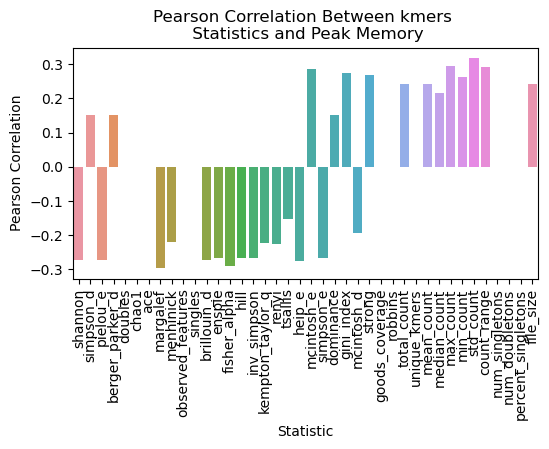

In [10]:
# Compute the Pearson correlation between each feature in stats_X and y
correlations = stats_X.corrwith(y["peak_mem_in_gbs"])

# Plot the correlations as a bar chart
plt.figure(figsize=(6, 3))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title("Pearson Correlation Between kmers \n Statistics and Peak Memory")
plt.xlabel("Statistic")
plt.ylabel("Pearson Correlation")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

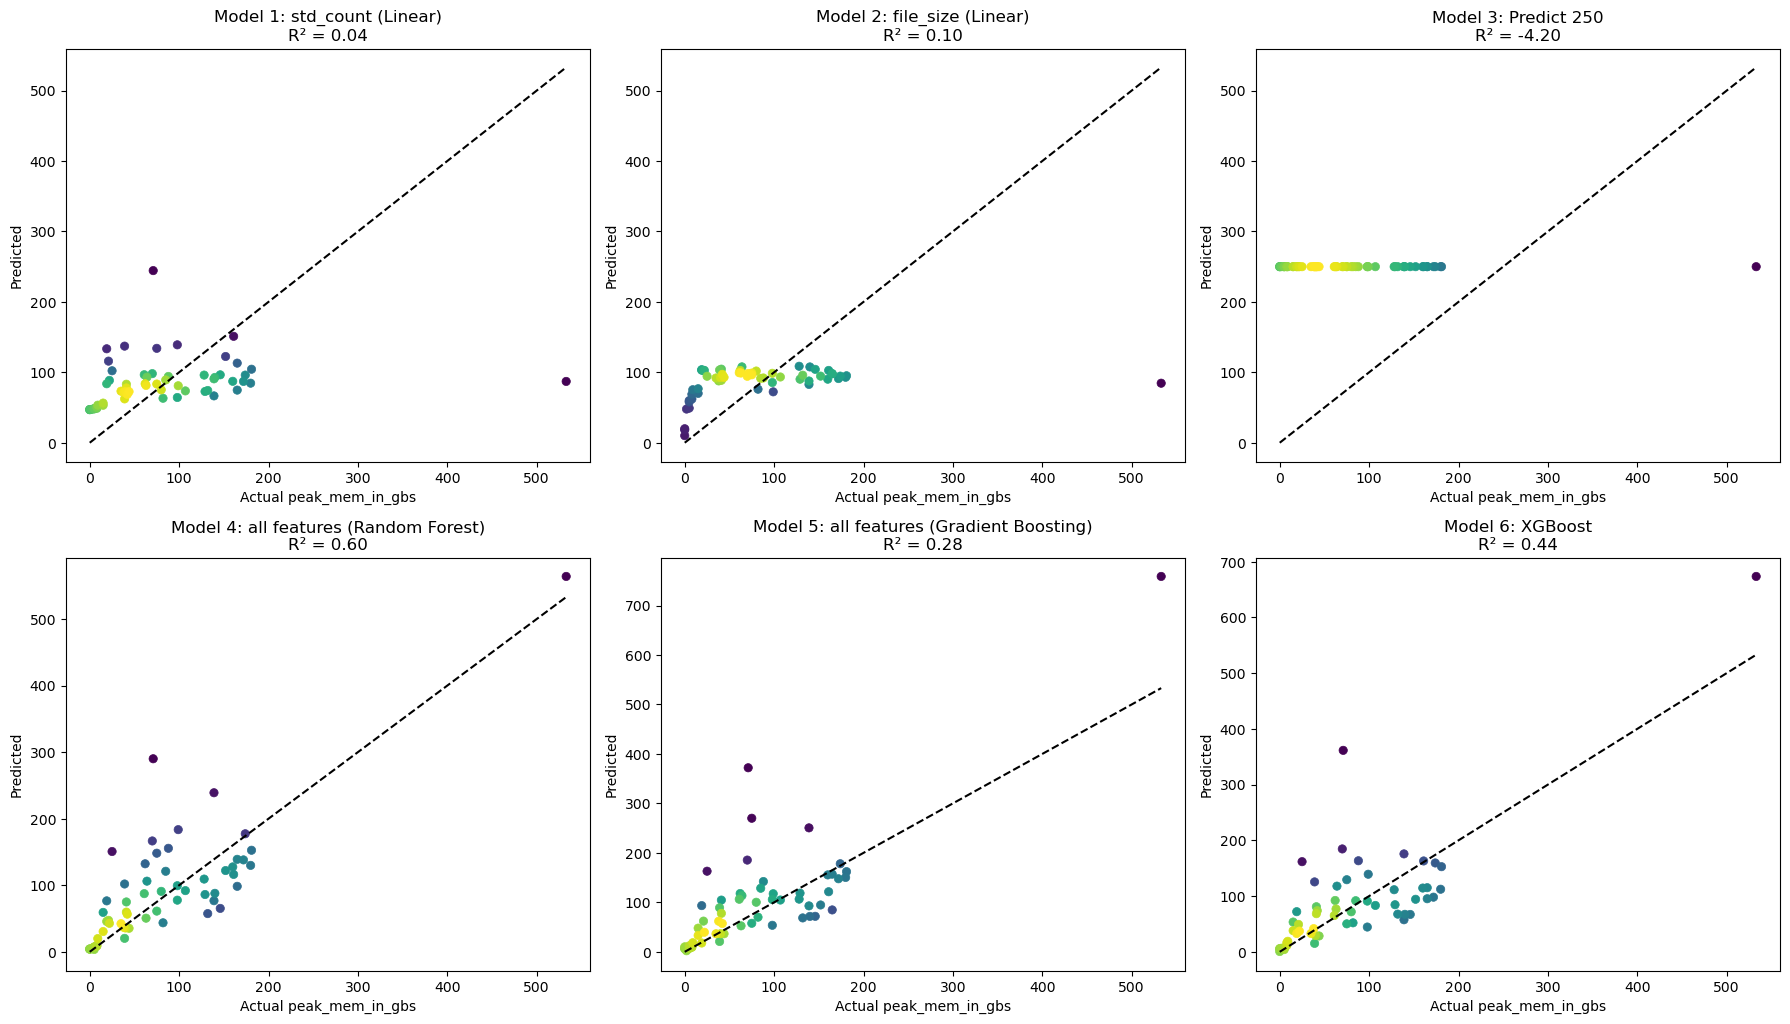

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from scipy.stats import gaussian_kde

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Feature sets
features_1 = ["std_count"]
features_2 = ["file_size"]
features_all = stats_X.columns.tolist()

# Model list: (title, features, model_instance)
models = [
    ("Model 1: Std. kmer count (Linear)", features_1, LinearRegression()),
    ("Model 2: File site (Linear)", features_2, LinearRegression()),
    ("Model 3: Predict 250", features_all, DummyRegressor(strategy="constant", constant=250)),
    ("Model 4: All features (Random Forest)", features_all, RandomForestRegressor(random_state=42)),
    ("Model 5: All features (Gradient Boosting)", features_all, GradientBoostingRegressor(random_state=42)),
    ("Model 6: All features (XGBoost", features_all, xgb.XGBRegressor(random_state=42, verbosity=0)),
]

# Plot setup
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (title, feat_list, model) in enumerate(models):
    X = stats_X[feat_list]
    X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    ax = axes[idx]

    # Calculate density for coloring
    xy = np.vstack([y_test, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort points by density so densest points plot on top
    idx_sort = z.argsort()
    x_sorted, y_sorted, z_sorted = y_test.iloc[idx_sort], y_pred[idx_sort], z[idx_sort]

    sns.scatterplot(x=x_sorted, y=y_sorted, hue=z_sorted, palette="viridis", ax=ax, legend=False, edgecolor=None)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    ax.set_title(f"{title}\nR² = {r2_score(y_test, y_pred):.2f}")
    ax.set_xlabel("Actual peak_mem_in_gbs")
    ax.set_ylabel("Predicted")

# Hide any unused subplots
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


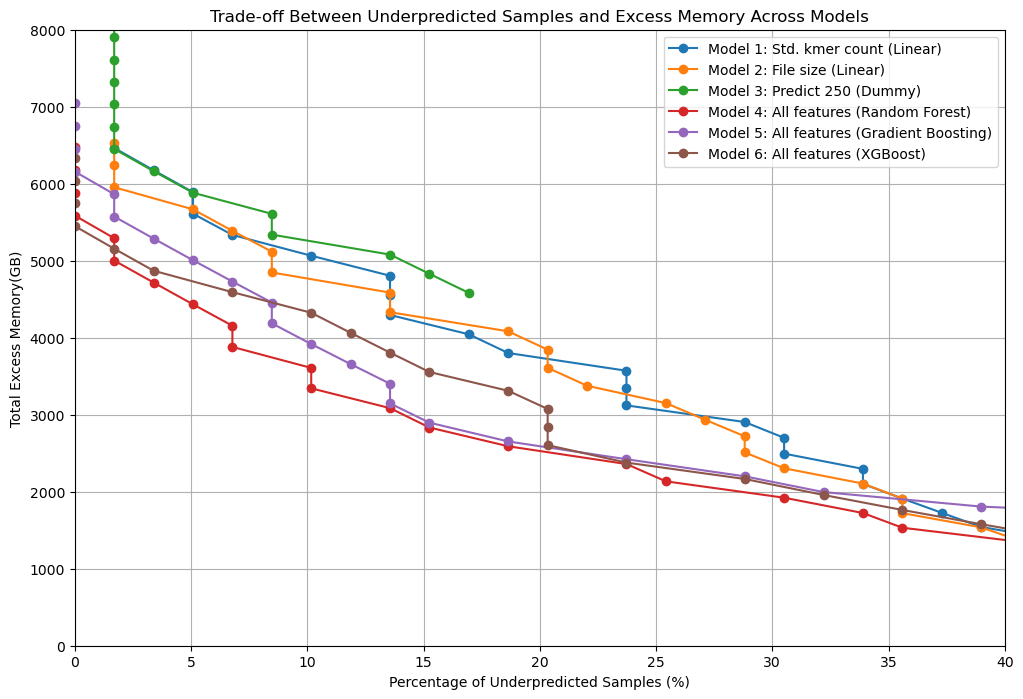

In [44]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Feature sets
features_1 = ["std_count"]
features_2 = ["file_size"]
features_all = stats_X.columns.tolist()

# Model list: (title, features, model_instance)
models = [
    ("Model 1: Std. kmer count (Linear)", features_1, LinearRegression()),
    ("Model 2: File size (Linear)", features_2, LinearRegression()),
    ("Model 3: Predict 250 (Dummy)", features_all, DummyRegressor(strategy="constant", constant=250)),
    ("Model 4: All features (Random Forest)", features_all, RandomForestRegressor(random_state=42)),
    ("Model 5: All features (Gradient Boosting)", features_all, GradientBoostingRegressor(random_state=42)),
    ("Model 6: All features (XGBoost)", features_all, xgb.XGBRegressor(random_state=42, verbosity=0)),
]

# Adjustment range: from -100 to +100 in 5GB steps
adjustment_steps = np.arange(-100, 101, 5)

plt.figure(figsize=(12, 8))

for title, feat_list, model in models:
    X = stats_X[feat_list]
    X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred_base = model.predict(X_test)
    
    underpred_percent_list = []
    excess_memory_list = []
    n_samples = len(y_test)
    
    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        
        under_pred_mask = y_pred_adj < y_test
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / n_samples) * 100
        
        excess_memory = y_pred_adj[~under_pred_mask] - y_test[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)
        
        underpred_percent_list.append(under_pred_percent)
        excess_memory_list.append(total_excess_memory)
    
    plt.plot(underpred_percent_list, excess_memory_list, label=title, marker='o')

plt.xlabel("Percentage of Underpredicted Samples (%)")
plt.ylabel("Total Excess Memory(GB)")
plt.title("Trade-off Between Underpredicted Samples and Excess Memory Across Models")
plt.legend()
plt.grid(True)
plt.xlim(0, 40)
plt.ylim(0, 8000)
plt.show()


# Compare kmers vs file size

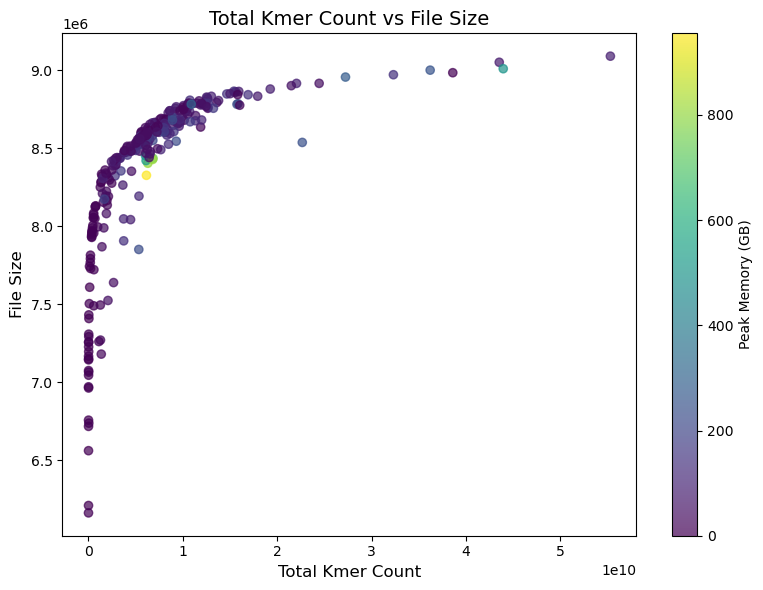

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Plot total_count vs file_size, color-coded by peak_mem_in_gbs
plt.figure(figsize=(8, 6))

# Use 'c' to color-code based on y["peak_mem_in_gbs"], and apply a colormap
scatter = plt.scatter(stats_X['total_count'], stats_X['file_size'], c=y['peak_mem_in_gbs'], cmap='viridis', alpha=0.7)

# Add labels and title
plt.title('Total Kmer Count vs File Size', fontsize=14)
plt.xlabel('Total Kmer Count', fontsize=12)
plt.ylabel('File Size', fontsize=12)

# Add a colorbar to show the scale of peak_mem_in_gbs
plt.colorbar(scatter, label='Peak Memory (GB)')

# Show the plot
plt.tight_layout()
plt.show()


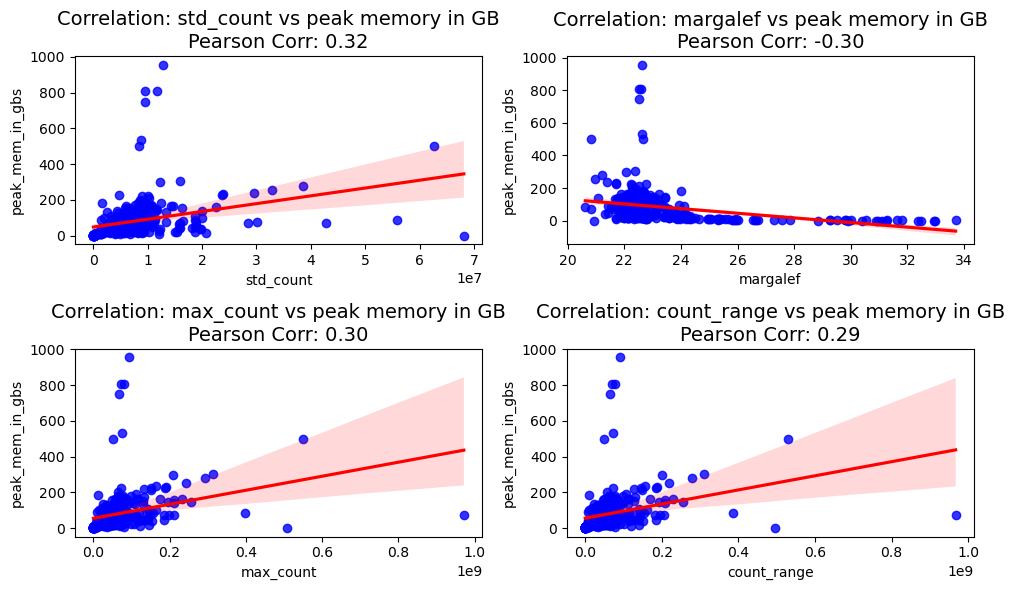

In [20]:
# Get the 4 most correlated features (both positive and negative)
top_4_features = correlations.abs().nlargest(4).index

# Set up the plot
plt.figure(figsize=(10, 6))

# Loop through the top 4 features and create a scatter plot with a regression line
for i, feature in enumerate(top_4_features, 1):
    plt.subplot(2, 2, i)
    
    # Compute the Pearson correlation between the feature and peak_mem_in_gbs
    pearson_corr, _ = pearsonr(stats_X[feature], y["peak_mem_in_gbs"])
    
    # Create the scatter plot with a regression line
    sns.regplot(x=stats_X[feature], y=y["peak_mem_in_gbs"], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    
    # Set titles and labels with the Pearson correlation coefficient
    plt.title(f"Correlation: {feature} vs peak memory in GB\nPearson Corr: {pearson_corr:.2f}", fontsize=14)
    plt.xlabel(feature)
    plt.ylabel('peak_mem_in_gbs')

# Adjust the layout for better presentation
plt.tight_layout()
plt.show()

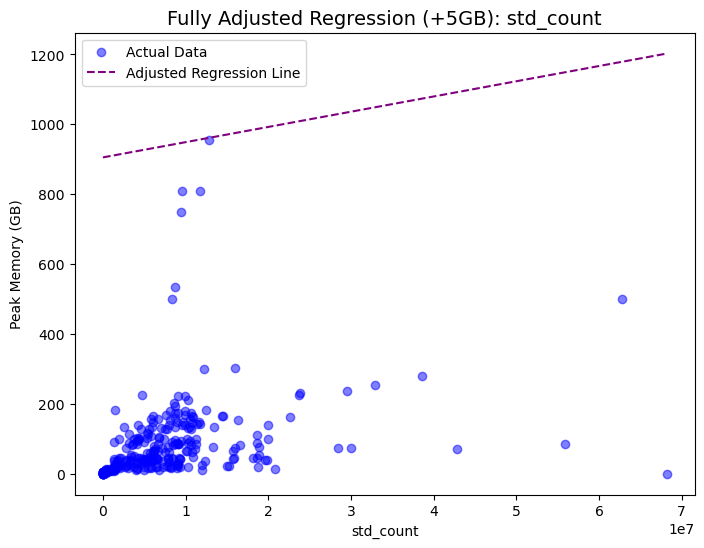

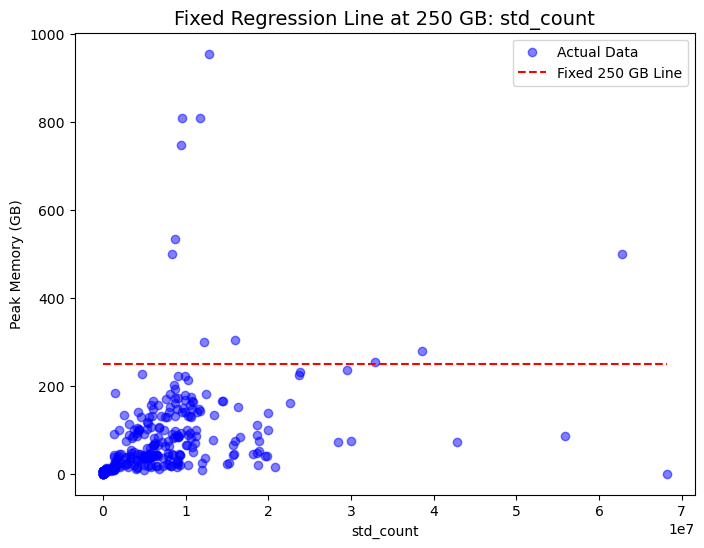

Final Intercept Adjustment (+5 GB): 857


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Select the feature related to "total count" (assuming it's the first feature in top_4_features)
feature = top_4_features[0]

# Prepare feature and target data
X_feature = stats_X[[feature]]
y_target = y["peak_mem_in_gbs"]

# Train original regression model
model = LinearRegression()
model.fit(X_feature, y_target)

# Compute original predictions
y_pred = model.predict(X_feature)

# Initialize intercept adjustment
intercept_adjustment = 0

# Gradually increase intercept until all points are below the line
while np.any(y_pred + intercept_adjustment < y_target):
    intercept_adjustment += 1  # Increase step by step

# Add extra 5 GB for safety
intercept_adjustment += 5

# Compute the final adjusted intercept
adjusted_intercept = model.intercept_ + intercept_adjustment

# Generate x values
x_vals = np.linspace(X_feature.min(), X_feature.max(), 100)

# Generate adjusted regression line
y_vals_adjusted = model.coef_[0] * x_vals + adjusted_intercept

# Generate fixed regression line at 250 GB
y_vals_fixed = np.full_like(x_vals, 250)

# Create the first plot (fully adjusted regression)
plt.figure(figsize=(8, 6))
plt.scatter(X_feature, y_target, color='blue', alpha=0.5, label="Actual Data")
plt.plot(x_vals, y_vals_adjusted, color='purple', linestyle='--', label="Adjusted Regression Line")
plt.title(f"Fully Adjusted Regression (+5GB): {feature}", fontsize=14)
plt.xlabel(feature)
plt.ylabel("Peak Memory (GB)")
plt.legend()
plt.show()

# Create the second plot (fixed line at 250 GB)
plt.figure(figsize=(8, 6))
plt.scatter(X_feature, y_target, color='blue', alpha=0.5, label="Actual Data")
plt.plot(x_vals, y_vals_fixed, color='red', linestyle='--', label="Fixed 250 GB Line")
plt.title(f"Fixed Regression Line at 250 GB: {feature}", fontsize=14)
plt.xlabel(feature)
plt.ylabel("Peak Memory (GB)")
plt.legend()
plt.show()

# Print the final intercept adjustment value
print(f"Final Intercept Adjustment (+5 GB): {intercept_adjustment}")


In [22]:
# Compare against current TPV rule: toolshed.g2.bx.psu.edu/repos/nml/metaspades/metaspades/.*: 250 GB

# Compute lost memory for the adjusted regression line
lost_memory_adjusted = (y_pred + intercept_adjustment) - y_target
total_lost_memory_adjusted = np.sum(lost_memory_adjusted)

# Compute lost memory for the fixed 250GB line
lost_memory_fixed = 250 - y_target
total_lost_memory_fixed = np.sum(lost_memory_fixed)

# Print results
print(f"Total Lost Memory (Adjusted Regression Line): {total_lost_memory_adjusted:.2f} GB")
print(f"Total Lost Memory (Fixed 250GB Line): {total_lost_memory_fixed:.2f} GB")

Total Lost Memory (Adjusted Regression Line): 252815.00 GB
Total Lost Memory (Fixed 250GB Line): 49788.00 GB


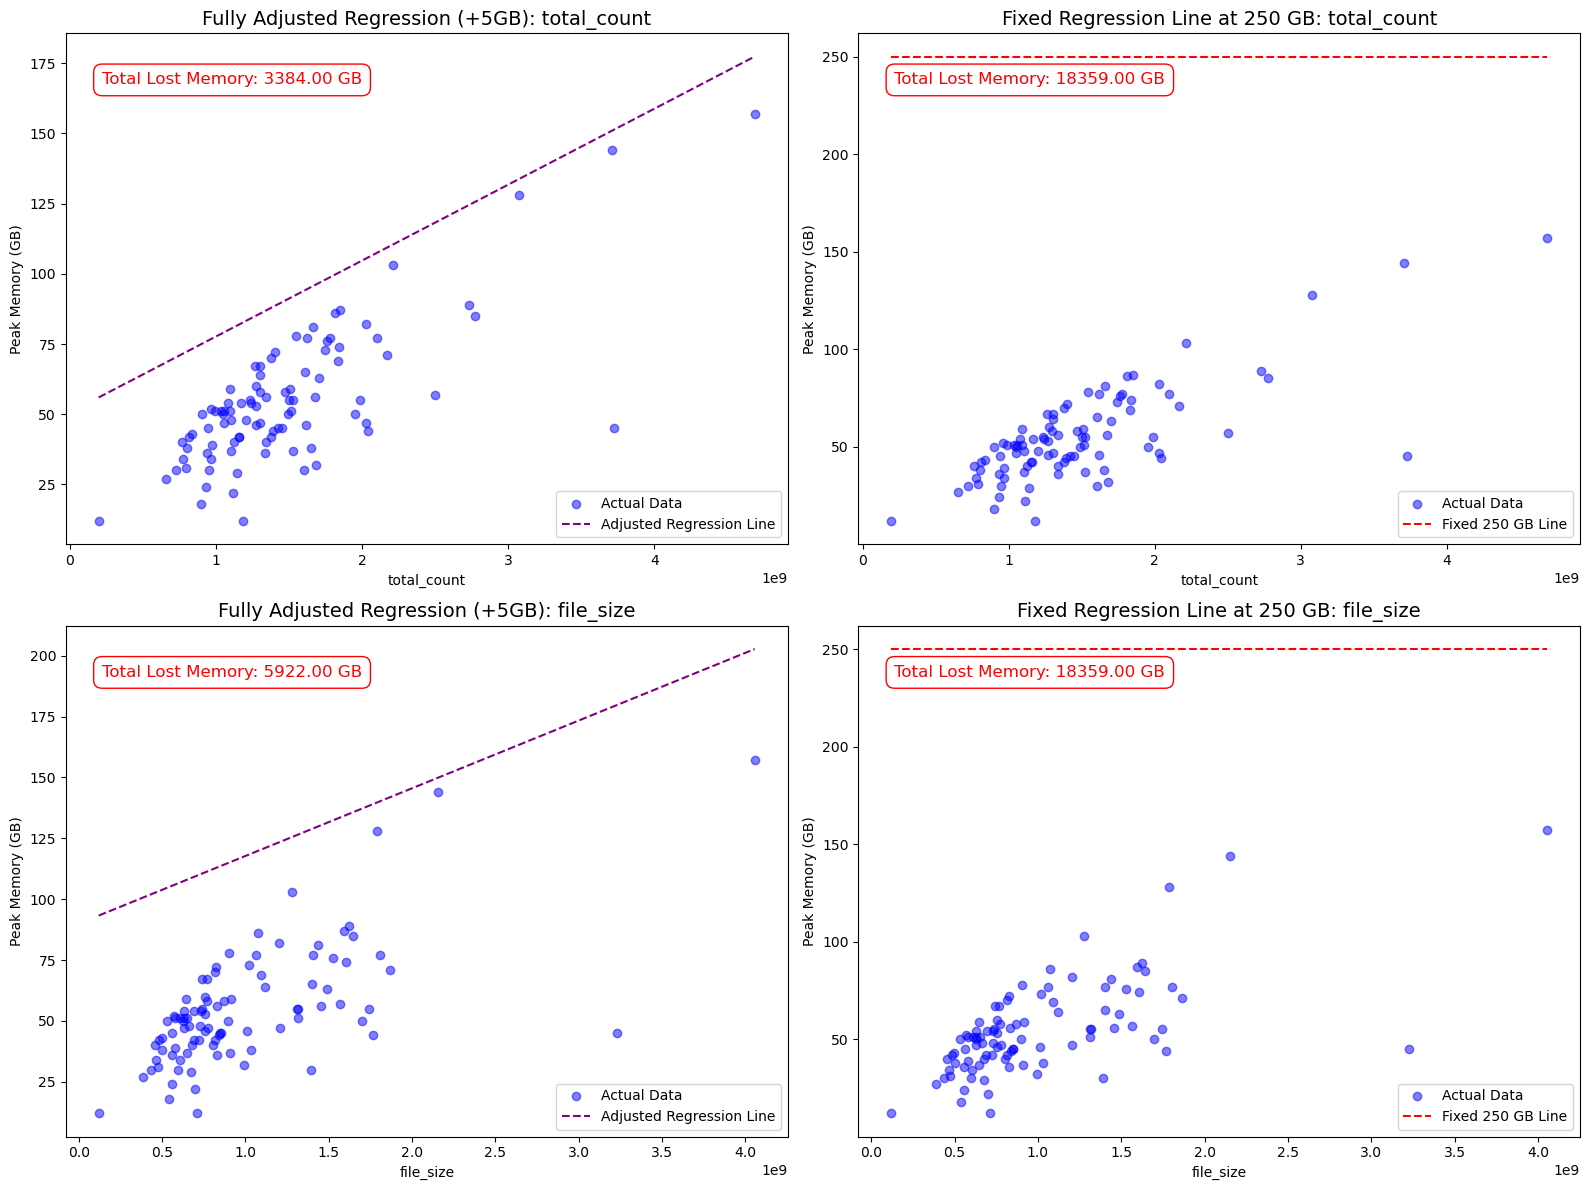

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Explicitly define the feature related to "total count" and "file_size"
total_count_feature = 'total_count'  # Replace with the actual name of the column if different
file_size_feature = 'file_size'  # Replace with the actual name of the column if different

# Prepare feature and target data
X_total_count = stats_X[[total_count_feature]]  # Feature: total_count
X_file_size = stats_X[[file_size_feature]]  # Feature: file_size
y_target = y["peak_mem_in_gbs"]

# Train original regression model for total_count
model_total_count = LinearRegression()
model_total_count.fit(X_total_count, y_target)

# Compute original predictions for total_count
y_pred_total_count = model_total_count.predict(X_total_count)

# Initialize intercept adjustment for total_count
intercept_adjustment_total_count = 0

# Gradually increase intercept until all points are below the line
while np.any(y_pred_total_count + intercept_adjustment_total_count < y_target):
    intercept_adjustment_total_count += 1  # Increase step by step

# Add extra 5 GB for safety for total_count
intercept_adjustment_total_count += 5

# Compute the final adjusted intercept for total_count
adjusted_intercept_total_count = model_total_count.intercept_ + intercept_adjustment_total_count

# Generate x values for total_count
x_vals_total_count = np.linspace(X_total_count.min(), X_total_count.max(), 100)

# Generate adjusted regression line for total_count
y_vals_adjusted_total_count = model_total_count.coef_[0] * x_vals_total_count + adjusted_intercept_total_count

# Generate fixed regression line at 250 GB for total_count
y_vals_fixed_total_count = np.full_like(x_vals_total_count, 250)

# Compute lost memory for the adjusted regression line (total_count)
lost_memory_adjusted_total_count = (y_pred_total_count + intercept_adjustment_total_count) - y_target
total_lost_memory_adjusted_total_count = np.sum(lost_memory_adjusted_total_count)

# Compute lost memory for the fixed 250GB line (total_count)
lost_memory_fixed_total_count = 250 - y_target
total_lost_memory_fixed_total_count = np.sum(lost_memory_fixed_total_count)

# Train original regression model for file_size
model_file_size = LinearRegression()
model_file_size.fit(X_file_size, y_target)

# Compute original predictions for file_size
y_pred_file_size = model_file_size.predict(X_file_size)

# Initialize intercept adjustment for file_size
intercept_adjustment_file_size = 0

# Gradually increase intercept until all points are below the line
while np.any(y_pred_file_size + intercept_adjustment_file_size < y_target):
    intercept_adjustment_file_size += 1  # Increase step by step

# Add extra 5 GB for safety for file_size
intercept_adjustment_file_size += 5

# Compute the final adjusted intercept for file_size
adjusted_intercept_file_size = model_file_size.intercept_ + intercept_adjustment_file_size

# Generate x values for file_size
x_vals_file_size = np.linspace(X_file_size.min(), X_file_size.max(), 100)

# Generate adjusted regression line for file_size
y_vals_adjusted_file_size = model_file_size.coef_[0] * x_vals_file_size + adjusted_intercept_file_size

# Generate fixed regression line at 250 GB for file_size
y_vals_fixed_file_size = np.full_like(x_vals_file_size, 250)

# Compute lost memory for the adjusted regression line (file_size)
lost_memory_adjusted_file_size = (y_pred_file_size + intercept_adjustment_file_size) - y_target
total_lost_memory_adjusted_file_size = np.sum(lost_memory_adjusted_file_size)

# Compute lost memory for the fixed 250GB line (file_size)
lost_memory_fixed_file_size = 250 - y_target
total_lost_memory_fixed_file_size = np.sum(lost_memory_fixed_file_size)

# Create a single figure with 1 row and 2 columns for the subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))  # 2x2 grid

# Plot for adjusted regression line (total_count)
axs[0, 0].scatter(X_total_count, y_target, color='blue', alpha=0.5, label="Actual Data")
axs[0, 0].plot(x_vals_total_count, y_vals_adjusted_total_count, color='purple', linestyle='--', label="Adjusted Regression Line")
axs[0, 0].set_title(f"Fully Adjusted Regression (+5GB): {total_count_feature}", fontsize=14)
axs[0, 0].set_xlabel(total_count_feature)
axs[0, 0].set_ylabel("Peak Memory (GB)")
axs[0, 0].legend()

# Annotate the total lost memory for adjusted line (total_count)
axs[0, 0].text(0.05, 0.9, f"Total Lost Memory: {total_lost_memory_adjusted_total_count:.2f} GB", 
               transform=axs[0, 0].transAxes, fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# Plot for fixed 250GB line (total_count)
axs[0, 1].scatter(X_total_count, y_target, color='blue', alpha=0.5, label="Actual Data")
axs[0, 1].plot(x_vals_total_count, y_vals_fixed_total_count, color='red', linestyle='--', label="Fixed 250 GB Line")
axs[0, 1].set_title(f"Fixed Regression Line at 250 GB: {total_count_feature}", fontsize=14)
axs[0, 1].set_xlabel(total_count_feature)
axs[0, 1].set_ylabel("Peak Memory (GB)")
axs[0, 1].legend()

# Annotate the total lost memory for fixed line (total_count)
axs[0, 1].text(0.05, 0.9, f"Total Lost Memory: {total_lost_memory_fixed_total_count:.2f} GB", 
               transform=axs[0, 1].transAxes, fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# Plot for adjusted regression line (file_size)
axs[1, 0].scatter(X_file_size, y_target, color='blue', alpha=0.5, label="Actual Data")
axs[1, 0].plot(x_vals_file_size, y_vals_adjusted_file_size, color='purple', linestyle='--', label="Adjusted Regression Line")
axs[1, 0].set_title(f"Fully Adjusted Regression (+5GB): {file_size_feature}", fontsize=14)
axs[1, 0].set_xlabel(file_size_feature)
axs[1, 0].set_ylabel("Peak Memory (GB)")
axs[1, 0].legend()

# Annotate the total lost memory for adjusted line (file_size)
axs[1, 0].text(0.05, 0.9, f"Total Lost Memory: {total_lost_memory_adjusted_file_size:.2f} GB", 
               transform=axs[1, 0].transAxes, fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# Plot for fixed 250GB line (file_size)
axs[1, 1].scatter(X_file_size, y_target, color='blue', alpha=0.5, label="Actual Data")
axs[1, 1].plot(x_vals_file_size, y_vals_fixed_file_size, color='red', linestyle='--', label="Fixed 250 GB Line")
axs[1, 1].set_title(f"Fixed Regression Line at 250 GB: {file_size_feature}", fontsize=14)
axs[1, 1].set_xlabel(file_size_feature)
axs[1, 1].set_ylabel("Peak Memory (GB)")
axs[1, 1].legend()

# Annotate the total lost memory for fixed line (file_size)
axs[1, 1].text(0.05, 0.9, f"Total Lost Memory: {total_lost_memory_fixed_file_size:.2f} GB", 
               transform=axs[1, 1].transAxes, fontsize=12, color='red', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.5'))

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plots
plt.show()


# Get the formula

In [60]:
# Calculate Pearson correlations for each feature with the target
feature_correlations = {}
for feature in X_stats.columns:
    pearson_corr_feature, _ = pearsonr(X_stats[feature], y_target)
    feature_correlations[feature] = abs(pearson_corr_feature)  # Use absolute correlation

# Sort features by correlation (absolute) and pick the most correlated feature
best_feature = max(feature_correlations, key=feature_correlations.get)

# Train the model using only the best feature
X_best_feature = X_stats[[best_feature]].fillna(0)  # Use only the best feature
model_best = LinearRegression()

# Fit the model on the best feature
model_best.fit(X_best_feature, y_target)

# Get the coefficient and intercept for the best feature
best_feature_coefficient = model_best.coef_[0]
best_feature_intercept = model_best.intercept_

# Display the formula without rounding
formula = f"peak_mem_in_gbs = {best_feature_intercept} + ({best_feature_coefficient}) * {best_feature}"
print("Formula to calculate peak_mem_in_gbs using the best feature:")
print(formula)

Formula to calculate peak_mem_in_gbs using the best feature:
peak_mem_in_gbs = 14.659170464915043 + (2.7040299802847846e-08) * total_count


/tmp/ipykernel_722235/878908768.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr_feature, _ = pearsonr(X_stats[feature], y_target)


# Compare features and model using CV -> fair comparison

Total Over-Prediction of Memory (GB) for All Features Model: 9523.46
Total Under-Prediction Instances for All Features Model: 129
Total Over-Prediction of Memory (GB) for Top 5 Features Model: 8975.64
Total Under-Prediction Instances for Top 5 Features Model: 113


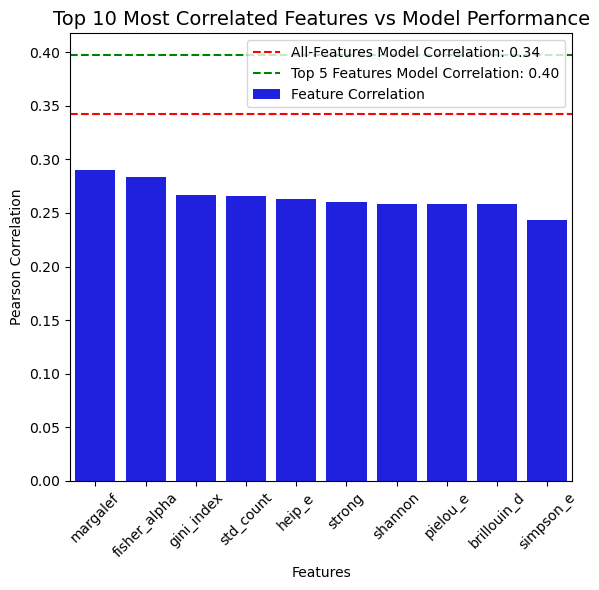

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict
from scipy.stats import pearsonr

# Ensure all column names are strings
X_stats = stats_X.fillna(0)
X_stats.columns = X_stats.columns.astype(str)

y_target = y["peak_mem_in_gbs"]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store Pearson correlations for each feature model
feature_correlations = {}

# Train models using one feature at a time
for feature in X_stats.columns:
    model = LinearRegression()
    
    # Get cross-validated predictions
    y_pred = cross_val_predict(model, X_stats[[feature]], y_target, cv=kf)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(y_target, y_pred)
    feature_correlations[feature] = abs(pearson_corr)  # Take absolute values

# Convert feature correlations to a DataFrame and get the top 10 features
feature_corr_df = pd.DataFrame.from_dict(feature_correlations, orient='index', columns=['Feature Correlation'])
feature_corr_df = feature_corr_df.sort_values(by='Feature Correlation', ascending=False)

# Get the top 5 features
top_5_features = feature_corr_df.head(5).index

# Train a model using all features with cross_val_predict
model_stats = LinearRegression()
y_pred_stats = cross_val_predict(model_stats, X_stats, y_target, cv=kf)

# Compute Pearson correlation for the full model
model_corr_stats, _ = pearsonr(y_target, y_pred_stats)

# Compute total over-prediction (sum of excess memory predicted)
total_over_prediction = np.sum(y_pred_stats[y_pred_stats > y_target] - y_target[y_pred_stats > y_target])

# Compute count of under-prediction instances (how many times prediction was too low)
total_under_pred_instances = np.sum(y_target > y_pred_stats)

# Train a model using the top 5 features with cross_val_predict
X_top_5 = X_stats[top_5_features]
model_top_5 = LinearRegression()
y_pred_top_5 = cross_val_predict(model_top_5, X_top_5, y_target, cv=kf)

# Compute Pearson correlation for the top 5 model
model_corr_top_5, _ = pearsonr(y_target, y_pred_top_5)

# Compute total over-prediction for the top 5 model
total_over_prediction_top_5 = np.sum(y_pred_top_5[y_pred_top_5 > y_target] - y_target[y_pred_top_5 > y_target])

# Compute count of under-prediction instances for the top 5 model
total_under_pred_instances_top_5 = np.sum(y_target > y_pred_top_5)

# Print over/under prediction values for both models
print(f"Total Over-Prediction of Memory (GB) for All Features Model: {total_over_prediction:.2f}")
print(f"Total Under-Prediction Instances for All Features Model: {total_under_pred_instances}")
print(f"Total Over-Prediction of Memory (GB) for Top 5 Features Model: {total_over_prediction_top_5:.2f}")
print(f"Total Under-Prediction Instances for Top 5 Features Model: {total_under_pred_instances_top_5}")

# Plot the top 10 most correlated features
plt.figure(figsize=(6, 6))
sns.barplot(x=feature_corr_df.head(10).index, y=feature_corr_df["Feature Correlation"].head(10), color="blue", label="Feature Correlation")

# Add model correlation to the plot
plt.axhline(model_corr_stats, color='red', linestyle='--', label=f'All-Features Model Correlation: {model_corr_stats:.2f}')
plt.axhline(model_corr_top_5, color='green', linestyle='--', label=f'Top 5 Features Model Correlation: {model_corr_top_5:.2f}')

# Labels and title
plt.title('Top 10 Most Correlated Features vs Model Performance', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()
